# Examining the choice of minimum $\Delta \chi^2$ with CMX Tile 66003

Tile 66003 has 3 exposures of 450s from SV0. Using VI redshifts, I examine the choice of minimum $\Delta \chi^2 = 40$ vs $100$
by looking at the true and false positive rates and looking at their spectra and redrock fits. 


Details of the exposures can be found in [TS SV0](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0)

In [1]:
import os
import glob
import h5py
import fitsio
import numpy as np 
from astropy import units as u
from astropy.coordinates import SkyCoord

from redrock import templates
from desitarget.cmx import cmx_targetmask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# read VI table
fvi = os.path.join('/global/cfs/cdirs/desi/sv/vi/TruthTables/', 'truth_table_BGS_full_66003.txt')#'truth_table_BGS_v1.1.csv')

vi_id, zrr_vi, ztrue, qa_flag, dchi2_vi, zwarn_vi, rflux_vi, vi_ra, vi_dec = np.genfromtxt(fvi, delimiter=',', skip_header=1, unpack=True, usecols=[1, 2, 4, 6, 11, 12, 16, -2, -1])# usecols=[0, 1, 2, 3, 10, 11, 15])
vi_id = vi_id.astype(int)

vi_coord = SkyCoord(ra=vi_ra*u.degree, dec=vi_dec*u.degree)

In [4]:
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [5]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate


def zsuccess(zrr, ztrue, zwarn, deltachi2=None, min_deltachi2=9.):
    ''' apply redshift success crition

    |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 

    :params zrr: 
        redrock best-fit redshift

    :params ztrue: 
        true redshift 

    :params zwarn: 
        zwarn flag value 

    :return crit: 
        boolean array indiciate which redshifts were successfully
        measured by redrock 
    '''
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    if deltachi2 is None: 
        crit = (dz_1pz < 0.003) & (zwarn == 0)
    else: 
        crit = (dz_1pz < 0.003) & (zwarn == 0) & (deltachi2 > min_deltachi2) 
    return crit

## $z$ success rate with $\Delta \chi^2=40$ vs $100$
Lets first see how much the redshift success rate is impacted by the choice of $\Delta \chi^2$

--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
  1264 successful r < 20 redshifts delta chi2=40
  1224 successful r < 20 redshifts delta chi2=100
--- 55655 ---
  2241 of 5000 BGS targets have matches to VI
  1270 successful r < 20 redshifts delta chi2=40
  1219 successful r < 20 redshifts delta chi2=100
--- 55656 ---
  2241 of 5000 BGS targets have matches to VI
  1241 successful r < 20 redshifts delta chi2=40
  1166 successful r < 20 redshifts delta chi2=100


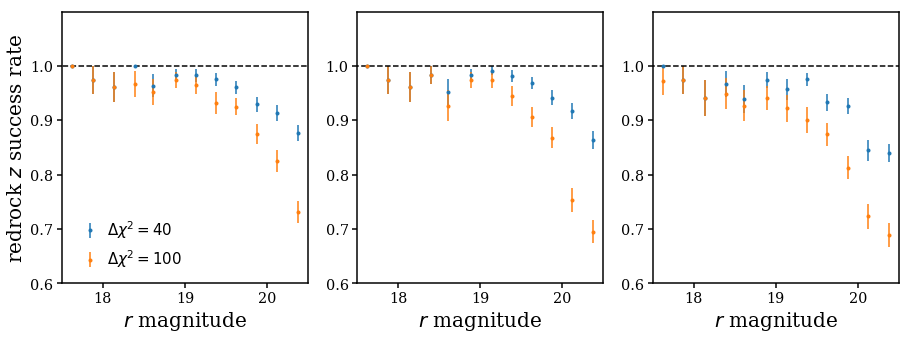

In [10]:
fig = plt.figure(figsize=(15,5)) 


expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    # compile coadds from the petals 
    n_bgs = 0 
    ras, decs, rmags, rfibs, z_rrs, zwarns, chi2s, dchi2s = [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        fluxes.append(coadd_flux[gal_cut,:])
        ras.append(coadd['TARGET_RA'][gal_cut])
        decs.append(coadd['TARGET_DEC'][gal_cut])
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])

        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
        
    # match VI targets to coadd targets using RA and DEC because there
    # seems to be a bug in the TARGETIDs
    ras = np.concatenate(ras)
    decs = np.concatenate(decs)
    
    coadd_coord = SkyCoord(ra=ras * u.deg, dec=decs * u.deg)
    _m_coadd, _d, _ = vi_coord.match_to_catalog_sky(coadd_coord)
    m_vi = (_d.to(u.deg).value < 1e-5)
    m_coadd = _m_coadd[m_vi]
    assert np.sum(_d.to(u.deg).value > 1e-5) == 0
    print('  %i of %i BGS targets have matches to VI' % (np.sum(m_vi), n_bgs))    
    
    fluxes = np.concatenate(fluxes, axis=0)[m_coadd]
    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]

    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
    
    zs_dchi2_40 = zsuccess(z_rrs, ztrue, zwarns, deltachi2=dchi2s, min_deltachi2=40)
    zs_dchi2_100 = zsuccess(z_rrs, ztrue, zwarns, deltachi2=dchi2s, min_deltachi2=100)
    
    print('  %i successful r < 20 redshifts delta chi2=40' % np.sum(zs_dchi2_40 & (rmags < 20.)))
    print('  %i successful r < 20 redshifts delta chi2=100' % np.sum(zs_dchi2_100 & (rmags < 20.)))
        
    sub = fig.add_subplot(1,3,i_exp+1)
    
    sub.plot([16, 21], [1.0, 1.0], c='k', ls='--') 
    wmean, rate, err_rate = zsuccess_rate(rmags, zs_dchi2_40, range=[15,22], nbins=28, bin_min=10) 
    sub.errorbar(wmean, rate, err_rate, fmt='.C0', label=r'$\Delta \chi^2 = 40$')
    wmean, rate, err_rate = zsuccess_rate(rmags, zs_dchi2_100, range=[15,22], nbins=28, bin_min=10) 
    sub.errorbar(wmean, rate, err_rate, fmt='.C1', label=r'$\Delta \chi^2 = 100$')
    sub.set_xlabel(r'$r$ magnitude', fontsize=20)
    sub.set_xlim(17.5, 20.5) 

    if i_exp == 0: 
        sub.set_ylabel(r'redrock $z$ success rate', fontsize=20)
        sub.legend(loc='lower left', handletextpad=0.1, fontsize=15)

    sub.set_ylim([0.6, 1.1])
    sub.set_yticks([0.6, 0.7, 0.8, 0.9, 1.]) 

There's a **significant** impact, especially for faint galaxies: ~5% at r~19.5, ~10% at r~20.

## "true positives" with $40 < \Delta \chi^2 < 100$
Spectra where redrock got the right redshifts but with $40 < \Delta \chi^2 < 100$

In [11]:
galaxy_templates = templates.Template('rrtemplate-galaxy.fits')

DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
  40 of 40 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives
--- 55655 ---
  2241 of 5000 BGS targets have matches to VI
  51 of 52 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives
--- 55656 ---
  2241 of 5000 BGS targets have matches to VI
  75 of 78 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives


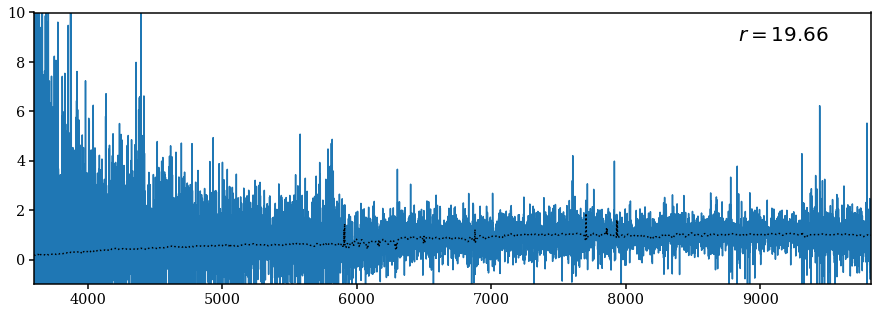

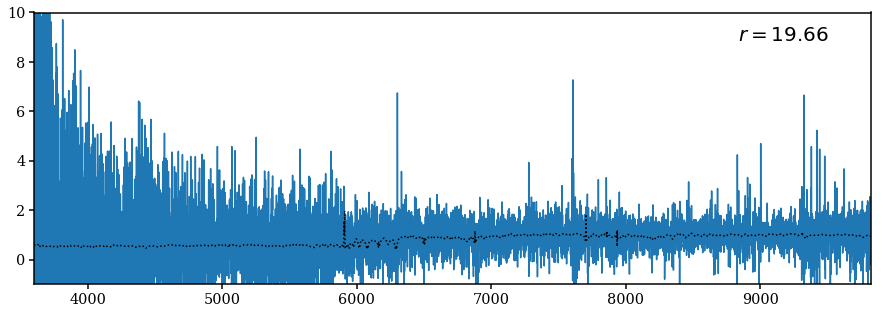

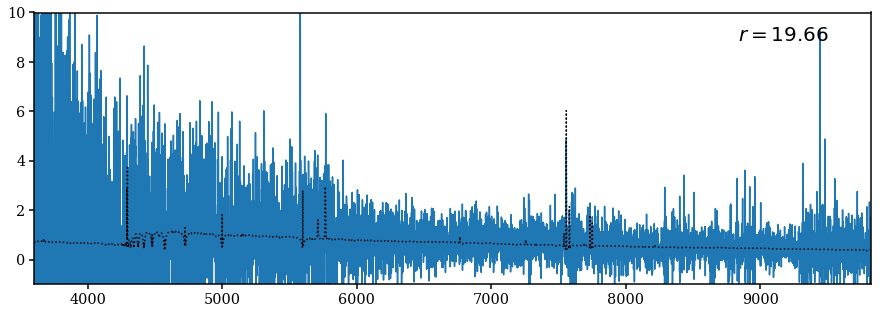

In [19]:
fig = plt.figure(figsize=(15,5)) 


expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    # compile coadds from the petals 
    n_bgs = 0 
    fluxes, ras, decs, rmags, rfibs, z_rrs, zwarns, zcoeffs, chi2s, dchi2s = [], [], [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        fluxes.append(coadd_flux[gal_cut])
        ras.append(coadd['TARGET_RA'][gal_cut])
        decs.append(coadd['TARGET_DEC'][gal_cut])
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])
        
        zcoeffs.append(zbest['COEFF'][gal_cut])
        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
        
    # match VI targets to coadd targets using RA and DEC because there
    # seems to be a bug in the TARGETIDs
    ras = np.concatenate(ras)
    decs = np.concatenate(decs)
    
    coadd_coord = SkyCoord(ra=ras * u.deg, dec=decs * u.deg)
    _m_coadd, _d, _ = vi_coord.match_to_catalog_sky(coadd_coord)
    m_vi = (_d.to(u.deg).value < 1e-5)
    m_coadd = _m_coadd[m_vi]
    assert np.sum(_d.to(u.deg).value > 1e-5) == 0
    print('  %i of %i BGS targets have matches to VI' % (np.sum(m_vi), n_bgs))    

    fluxes = np.concatenate(fluxes, axis=0)[m_coadd]
    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]

    zcoeffs = np.concatenate(zcoeffs, axis=0)[m_coadd]
    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
    
    dz_1pz = np.abs(ztrue - z_rrs)/(1.+ztrue)
    true_positive = (dz_1pz < 0.003) & (zwarns == 0) & (dchi2s > 40.) & (dchi2s < 100.) & (rmags < 20.)        
    n_tp = np.sum(true_positive)
    n_pass = np.sum((zwarns == 0) & (dchi2s > 40.) & (dchi2s < 100.) & (rmags < 20.))
    print('  %i of %i r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are true positives' % (np.sum(true_positive), n_pass)) 
       
    bestfit_template = galaxy_templates.eval(zcoeffs[true_positive,:][0], coadd_wave, z_rrs[true_positive][0]) * (1+z_rrs[true_positive][0])
    
    
    fig = plt.figure(figsize=(15,5))
    sub = fig.add_subplot(111)
    sub.plot(coadd_wave, fluxes[true_positive,:][0])
    sub.plot(coadd_wave, bestfit_template, c='k', ls=':')
    sub.text(0.95, 0.95, r'$r=%.2f$' % rmags[0], transform=sub.transAxes, ha='right', va='top', fontsize=20)
    sub.set_xlim(coadd_wave.min(), coadd_wave.max())
    sub.set_ylim(-1., 10)


## "false positives" with $40 < \Delta \chi^2 < 100$
Spectra that redrock *thinks* it got the right redshifts (ZWARN = 0 and $\Delta \chi^2 > 40$) but was wrong

--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
  0 of 40 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are false positives
--- 55655 ---
  2241 of 5000 BGS targets have matches to VI
  1 of 52 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are false positives
--- 55656 ---
  2241 of 5000 BGS targets have matches to VI
  3 of 78 r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are false positives


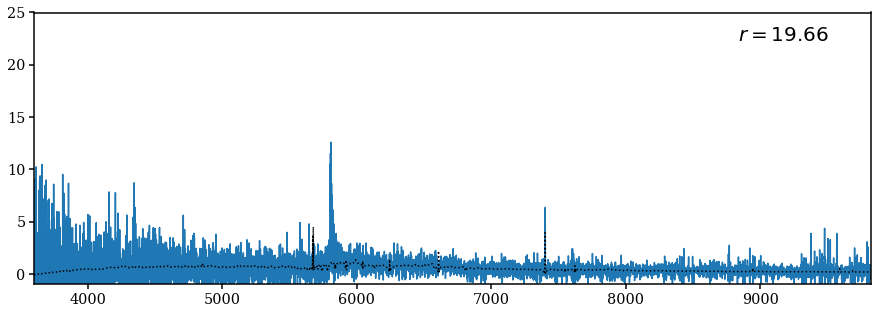

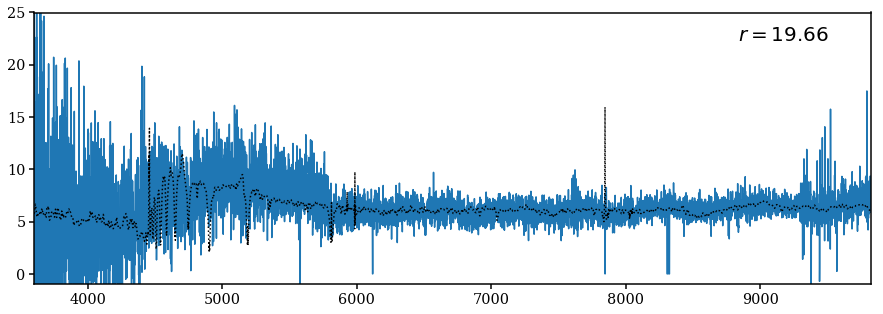

In [25]:
fig = plt.figure(figsize=(15,5)) 


expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])
for i_exp, expid in enumerate(expids): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    # compile coadds from the petals 
    n_bgs = 0 
    fluxes, ras, decs, rmags, rfibs, z_rrs, zwarns, zcoeffs, chi2s, dchi2s = [], [], [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        fluxes.append(coadd_flux[gal_cut])
        ras.append(coadd['TARGET_RA'][gal_cut])
        decs.append(coadd['TARGET_DEC'][gal_cut])
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])
        
        zcoeffs.append(zbest['COEFF'][gal_cut])
        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
        
    # match VI targets to coadd targets using RA and DEC because there
    # seems to be a bug in the TARGETIDs
    ras = np.concatenate(ras)
    decs = np.concatenate(decs)
    
    coadd_coord = SkyCoord(ra=ras * u.deg, dec=decs * u.deg)
    _m_coadd, _d, _ = vi_coord.match_to_catalog_sky(coadd_coord)
    m_vi = (_d.to(u.deg).value < 1e-5)
    m_coadd = _m_coadd[m_vi]
    assert np.sum(_d.to(u.deg).value > 1e-5) == 0
    print('  %i of %i BGS targets have matches to VI' % (np.sum(m_vi), n_bgs))    

    fluxes = np.concatenate(fluxes, axis=0)[m_coadd]
    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]

    zcoeffs = np.concatenate(zcoeffs, axis=0)[m_coadd]
    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
    
    dz_1pz = np.abs(ztrue - z_rrs)/(1.+ztrue)
    false_positive = (dz_1pz >= 0.003) & (zwarns == 0) & (dchi2s > 40.) & (dchi2s < 100.) & (rmags < 20.)            
    n_fp = np.sum(false_positive)
    n_pass = np.sum((zwarns == 0) & (dchi2s > 40.) & (dchi2s < 100.) & (rmags < 20.))
    print('  %i of %i r < 20. galaxies with ZWARN=0 and 40 < delta chi^2 < 100 are false positives' % (np.sum(false_positive), n_pass)) 
           
    if n_fp > 0: 
        bestfit_template = galaxy_templates.eval(zcoeffs[false_positive,:][0], coadd_wave, z_rrs[false_positive][0]) * (1+z_rrs[false_positive][0])

        fig = plt.figure(figsize=(15,5))
        sub = fig.add_subplot(111)
        sub.plot(coadd_wave, fluxes[false_positive,:][0])
        sub.plot(coadd_wave, bestfit_template, c='k', ls=':')
        sub.text(0.95, 0.95, r'$r=%.2f$' % rmags[0], transform=sub.transAxes, ha='right', va='top', fontsize=20)
        sub.set_xlim(coadd_wave.min(), coadd_wave.max())
        sub.set_ylim(-1., 25)


Out of 170 spectra, 4 false positives